<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/GP_spiral_scans_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian processes for sparse imaging

Prepared by Maxim Ziatdinov (November 2019)

Edited by Kyle Kelley 

E-mail: ziatdinovmax@gmail.com

---

This notebook applies Gaussian process regression to 2D sparse microscopy scans. The code itself is available from https://github.com/ziatdinovmax/GP (it will download and install itself and all the needed modules automatically when you run "Install/import modules" notebook cell). This package is under active development so there may be some bugs and rough edges. If something doesn't work properly, please email me at ziatdinovmax@gmail.com or file an issue on the project's github page.

---



In [0]:
#@title Download experimental data { form-width: "20%" }
%%shell
download_link="https://drive.google.com/uc?id=1-8tGYn35QfgLS3aNBL2p5fxt14_knXvX"
gdown $download_link -O spiral_data.zip
unzip spiral_data.zip
rm spiral_data.zip



Downloading...
From: https://drive.google.com/uc?id=1-8tGYn35QfgLS3aNBL2p5fxt14_knXvX
To: /content/spiral_data.zip
2.37MB [00:00, 75.2MB/s]
Archive:  spiral_data.zip
  inflating: CIPS_16scans_amp        
  inflating: CIPS_16scans_phase      
  inflating: CIPS_24scans_amp.mat    
  inflating: CIPS_24scans_phase.mat  
  inflating: CIPS_64Scans_amp.mat    
  inflating: CIPS_64scans_phase.mat  
  inflating: CIPS_8scans_amp.mat     
  inflating: CIPS_8scans_phase.mat   


In [0]:
%%shell
download_link="https://drive.google.com/uc?export=download&id=11GOpu-LTzagq4XuF8PLwTEy4vIkVr4IC"
gdown $download_link -O Others.zip
unzip Others.zip
rm Others.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=11GOpu-LTzagq4XuF8PLwTEy4vIkVr4IC
To: /content/Others.zip
100% 591k/591k [00:00<00:00, 39.5MB/s]
Archive:  Others.zip
   creating: Others/
  inflating: Others/CIPS_32Scans_amp.mat  
  inflating: Others/GroundTruth.mat  


In [0]:
#@title Install/Import modules { form-width: "20%" }
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

if 'GP' not in os.path.split(os.getcwd()):
    try:
        os.chdir('GP')
    except FileNotFoundError:
        print("Cloning package for GP analysis of hyperspectral data...", end=" ")
        !git clone -q https://github.com/ziatdinovmax/GP.git
        os.chdir('GP')
        print("Done")
        print("\nInstalling required libraries for GP analysis of hyperspectral data...")
        !python3 -m pip install -qq -r req.txt
        print("Done\n")
import torch
from gprocess import gprutils, skgpr, gpr
torch.set_default_tensor_type(torch.DoubleTensor)

Cloning package for GP analysis of hyperspectral data... Done

Installing required libraries for GP analysis of hyperspectral data...
     |████████████████████████████████| 7.7MB 7.4MB/s 
     |████████████████████████████████| 501kB 39.3MB/s 
     |████████████████████████████████| 235kB 41.4MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
Done



In [0]:
#@title Helper functions
def loadmatfile(matfile, verbose=0):
    loaded_file = loadmat(matfile)
    if verbose:
        print(loaded_file.keys())
    return loaded_file

def get_images(loaded_dict):
    return loaded_dict['image'], loaded_dict['CS_image']

def SSTEM(yspar,mask,itern,levels,lambd):
   
############################################
#INPUT: 
#yspar: sparse image as an array, to reduce iteration numer, better rescaling the value to [0,1]
#mask: binary array, 1 indicationg sampled pixel locations
#itern: iteration number, usually 20 is enough
#levels: wavelet level, common choice 2,3,4, larger value for larger feature size, if too blur, change to smaller one
#lambd: threshold value, usually 0.8 is fine

#Output: Inpaited image
#############################################   
    fSpars = yspar
    W_thr = [0]*levels;

    ProjC = lambda f, Omega: (1-Omega)*f + Omega*yspar
    
    for i in range(itern):
        fSpars = ProjC(fSpars, mask)
        W_pro = pywt.swt2(fSpars, 'db2',levels)
        for j in range(levels):
            sA = W_pro[j][0]
            sH = W_pro[j][1][0]
            sV = W_pro[j][1][1]
            sD = W_pro[j][1][2]
            W_thr[j] = (pywt.threshold(sA,0,'soft')),(pywt.threshold(sH,lambd,'soft'),
                        pywt.threshold(sV,lambd,'soft'),pywt.threshold(sD,lambd,'soft'))    
        fSpars = pywt.iswt2(W_thr,'db2')
    return fSpars

from google.colab import files
import pywt

Import ground truth image

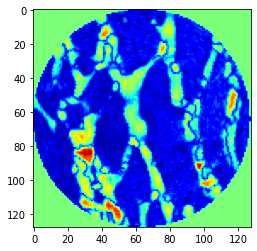

In [0]:
matfile = '/content/Others/GroundTruth.mat'
imgdata_gt, cs_data_gt = get_images(loadmatfile(matfile))

plt.figure()
plt.imshow(imgdata_gt, cmap='jet')


Making mask for mean square error calculations:


In [0]:
R2 = (imgdata_gt - np.min(imgdata_gt)) / np.ptp(imgdata_gt)
R2[R2 == R2[1, 1]] = 0



Functions for CS and GP iterations:


In [0]:
def GP_Structured(imgdata,iter__):
  
  R = (imgdata - np.min(imgdata)) / np.ptp(imgdata)
  R[R == R[1, 1]] = np.nan # Take value at [1, 1] as missing data value

  
  # Construct a grid for the FOV:
  e1, e2 = R.shape
  xx, yy = np.mgrid[:e1:1., :e2:1.]
  X_true = np.array([xx, yy])
  # Get sparse grid corresponding to measurements
  X, R = gprutils.corrupt_data_xy(X_true, R)

  lengthscale = [[1., 1.], [4., 4.]]
  # type of kernel ('RBF' or 'Matern52')
  kernel = 'RBF'
  
  
  err_calc = []
  for ii in range(iter__):
    skreconstructor = skgpr.skreconstructor(X, R, X_true, kernel, 
                                            lengthscale=lengthscale,
                                            input_dim=2, grid_points_ratio=1.,  
                                            learning_rate=0.1, iterations=ii, 
                                            calculate_sd=True, num_batches=1,
                                            use_gpu=True, verbose=True)
    (mean, sd), hyperparams = skreconstructor.run()
    # lengthscale constraints
    # lengthscale = [[1., 1.], [4., 4.]]
    # # type of kernel ('RBF' or 'Matern52')
    # kernel = 'RBF'
    # # Run GP
    # reconstructor = gpr.reconstructor(X, R, X_true, kernel,
    #                                   lengthscale=lengthscale,
    #                                   input_dim=2, indpoints=200, 
    #                                   learning_rate=0.1, iterations=ii, 
    #                                   use_gpu=True, verbose=True)
    # mean, sd, hyperparams = reconstructor.run()

    gt = imgdata_gt
    gt_norm =(gt - gt.min()) / (gt.max() - gt.min())

    gp_data= mean.reshape(128,128)
    gp_data_norm = (gp_data -gp_data.min())/ np.ptp(gp_data)
    # gp_data_norm = np.zeros((128,128))

    gt_norm[R2 == 0] = 0
    gp_data_norm[R2 ==0] = 0

    gp_data_norm_mask = []
    gt_norm_mask = []

    gt_norm_mask.append(gt_norm[R2 != 0])
    gp_data_norm_mask.append(gp_data_norm[R2 != 0])

    gp_data_norm_mask = np.array(gp_data_norm_mask)
    gt_norm_mask = np.array(gt_norm_mask)

    difference_mat_gp= np.sum((gt_norm_mask - gp_data_norm_mask)**2)/gt_norm_mask.shape[1]
    err_calc.append(difference_mat_gp)
  
  gp_err = (np.abs(gp_data_norm - gt_norm)/gt_norm)
  return err_calc,gp_data_norm,gp_err


In [0]:
def CS_Error(file,iter__,levels):

  data_raw = loadmat(file)
  yspar = data_raw['image']
  imgdata = yspar

  data_ = loadmat(file)
  data = data_['image']


  data[data == data[1,1]] = 0
  data[data != 0] = 1

  mask_cs = data
  
  err_calc = []
  for ij in range(iter__):
    
    itern = ij
    levels = levels
    lambd = 5

    y_recon = SSTEM(yspar,mask_cs,itern,levels,lambd)
    y_recon_norm = (y_recon - np.min(y_recon))/np.ptp(y_recon)

    gt = imgdata_gt
    gt_norm =(gt - gt.min()) / (gt.max() - gt.min())

    cs_data_norm = y_recon_norm

    gt_norm[R2 == 0] = 0
    cs_data_norm[R2 ==0] = 0

    cs_data_norm_mask = []
    gt_norm_mask = []

    gt_norm_mask.append(gt_norm[R2 != 0])
    cs_data_norm_mask.append(cs_data_norm[R2 != 0])

    cs_data_norm_mask = np.array(cs_data_norm_mask)
    gt_norm_mask = np.array(gt_norm_mask)



    difference_mat_cs = np.sum((gt_norm_mask - cs_data_norm_mask)**2)/gt_norm_mask.shape[1]
    err_calc.append(difference_mat_cs)
  cs_err = (np.abs(cs_data_norm - gt_norm)/gt_norm)
  return err_calc,cs_data_norm,cs_err


Calculate mean square error vs number of iterations:


Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.8873 ... length: [2.5 2.5] ... noise: 0.6932472 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.8894 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8434 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.8885 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8435 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.7942 ... length: [2.6491 2.6491] ... noise: 0.5982058 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.8897 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8412 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.7962 ... length: [2.6493 2.6493] ... noise

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


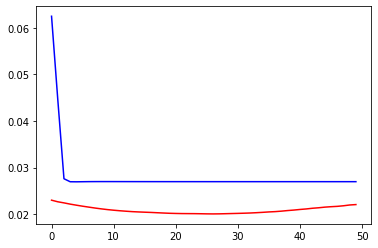

In [0]:
matfile = '/content/Others/CIPS_32Scans_amp.mat'
imgdata_32, cs_data_32 = get_images(loadmatfile(matfile))
err_calc32,gp_data_norm32,gp_err32 = GP_Structured(imgdata_32,50);

cserr_calc32,cs_data_norm32,cs_err32 = CS_Error(matfile,50,1)

plt.figure()
plt.plot(err_calc32, color = 'red',label = 'GP')
plt.plot(cserr_calc32, color = 'blue',label = 'CS')

Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.9018 ... length: [2.5 2.5] ... noise: 0.6932472 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.9053 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8518 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.905 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8519 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.8062 ... length: [2.649 2.649] ... noise: 0.5982041 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.9036 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8571 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.812 ... length: [2.6488 2.6488] ... noise: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


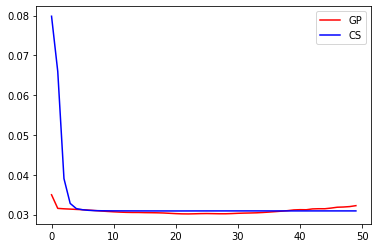

In [0]:
matfile = '/content/CIPS_24scans_amp.mat'
imgdata_24, cs_data_24 = get_images(loadmatfile(matfile))
err_calc24,gp_data_norm24,gp_err24 = GP_Structured(imgdata_24,50);

cserr_calc24,cs_data_norm24,cs_err24 = CS_Error(matfile,50,1)

plt.figure()
plt.plot(err_calc24, color = 'red',label = 'GP')
plt.plot(cserr_calc24, color = 'blue',label = 'CS')
plt.legend()



Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.9047 ... length: [2.5 2.5] ... noise: 0.6932472 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.9077 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8595 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.9086 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8598 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.8109 ... length: [2.6494 2.6494] ... noise: 0.5982146 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.9086 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8582 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.8116 ... length: [2.6486 2.6486] ... noise

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


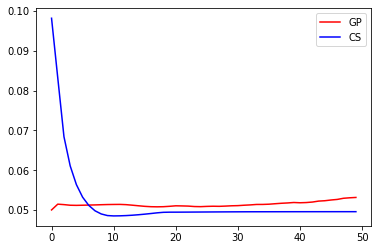

In [0]:
matfile = '/content/CIPS_16scans_amp'
imgdata_16, cs_data_16 = get_images(loadmatfile(matfile))
err_calc16,gp_data_norm16,gp_err16 = GP_Structured(imgdata_16,50)

cserr_calc16,cs_data_norm16,cs_err16 = CS_Error(matfile,50,1)

plt.figure()
plt.plot(err_calc16, color = 'red',label = 'GP')
plt.plot(cserr_calc16, color = 'blue',label = 'CS')
plt.legend()

Model training...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.8907 ... length: [2.5 2.5] ... noise: 0.6932472 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.895 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8452 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.8953 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8437 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.8016 ... length: [2.6488 2.6488] ... noise: 0.5981944 ...
Calculating predictive mean and uncertainty...
Batch 1/1
Done
Model training...
iter: 0 ... loss: 0.8893 ... length: [2.5 2.5] ... noise: 0.6932472 ...
iter: 1 ... loss: 0.8457 ... length: [2.5749 2.5749] ... noise: 0.6444967 ...
iter: 2 ... loss: 0.8002 ... length: [2.6384 2.6384] ... noise:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


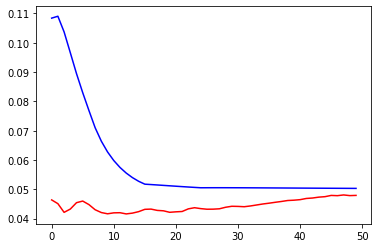

In [0]:
matfile = '/content/CIPS_8scans_amp.mat'
imgdata_8, cs_data_8 = get_images(loadmatfile(matfile))
err_calc8,gp_data_norm8,gp_err8 = GP_Structured(imgdata_8,50)

cserr_calc8,cs_data_norm8,cs_err8 = CS_Error(matfile,50,3)

plt.figure()
plt.plot(err_calc8, color = 'red',label = 'GP')
plt.plot(cserr_calc8, color = 'blue',label = 'CS')

[]

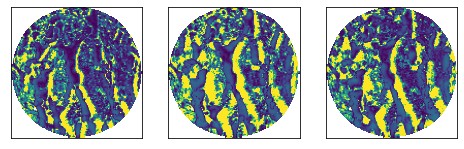

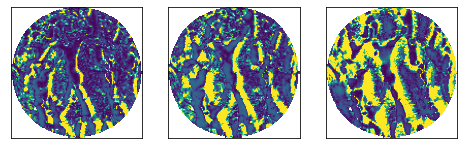

In [0]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 5))

ax1.imshow(gp_err24*100, cmap='viridis',clim=(0,250))
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(gp_err16*100, cmap='viridis',clim=(0,250))
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(gp_err8*100, cmap='viridis',clim=(0,250))
ax3.set_xticks([])
ax3.set_yticks([])

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 5))

ax1.imshow(cs_err24*100,cmap='viridis',clim=(0,250))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(cs_err16*100, cmap='viridis',clim=(0,250))
ax2.set_xticks([])
ax2.set_yticks([])
ax3.imshow(cs_err8*100, cmap='viridis',clim=(0,250))
ax3.set_xticks([])
ax3.set_yticks([])


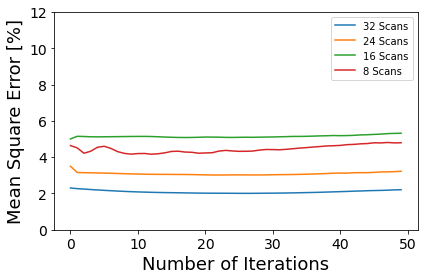

In [0]:
iteration = np.linspace(0,49)

plt.figure()
plt.plot(iteration,np.asarray(err_calc32)*100, label = '32 Scans')
plt.plot(iteration,np.asarray(err_calc24)*100, label = '24 Scans')
plt.plot(iteration,np.asarray(err_calc16)*100,label = '16 Scans')
plt.plot(iteration,np.asarray(err_calc8)*100, label = '8 Scans')
plt.legend(frameon='False')
plt.ylim(0,12)
plt.xticks(size =14)
plt.yticks(size =14)
plt.xlabel('Number of Iterations',size = 18)
plt.ylabel('Mean Square Error [%]',size =18)
plt.tight_layout()

# plt.savefig('GP_allscansErr.pdf', dpi = 600)
# files.download('GP_allscansErr.pdf')

0.04446958965029659 0.051450936645787725


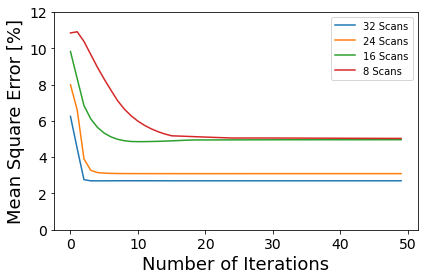

In [0]:
plt.figure()
plt.plot(iteration,np.asarray(cserr_calc32)*100, label = '32 Scans')
plt.plot(iteration,np.asarray(cserr_calc24)*100, label = '24 Scans')
plt.plot(iteration,np.asarray(cserr_calc16)*100, label = '16 Scans')
plt.plot(iteration,np.asarray(cserr_calc8)*100, label = '8 Scans')
plt.ylim(0,12)
plt.legend()
plt.xticks(size =14)
plt.yticks(size =14)
plt.xlabel('Number of Iterations',size = 18)
plt.ylabel('Mean Square Error [%]',size =18)
plt.tight_layout()

# plt.savefig('cs_allscansErr.pdf', dpi = 600)
# files.download('cs_allscansErr.pdf')

0.049606523633485645